In [1]:
from google.colab import drive

drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Colab Notebooks/Victor" "/content/Colab Notebooks/Victor"
%cd /gdrive/My Drive/Colab Notebooks/Victor

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link '/content/Colab Notebooks/Victor': No such file or directory
/gdrive/My Drive/Colab Notebooks/Victor


In [2]:
!pip install imblearn
!pip install memory-profiler
!pip install gputil
!pip install psutil
!pip install humanize

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from pathlib import Path

import os,sys,humanize,psutil,GPUtil

In [4]:
DATASET_IMAGE = ['Dataset/k_fold/fold_1', 'Dataset/k_fold/fold_3', 'Dataset/k_fold/fold_4', 'Dataset/k_fold/fold_5']
DATASET_IMAGE_TEST = ['Dataset/k_fold/fold_2']

W_H_SIZE = 112

In [5]:
# fungsi untuk melakukan record resource pada google collab
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [6]:
def min_max_scaler(data):
    # membuat data menjadi 1 array (flatten)
    data = np.array(data)
    flattened_data = data.flatten()

    # shape = (100,)
    # shape = (100, 1)

    scaler = MinMaxScaler()

    # menggunakan proses normalisasi nya
    scaler.fit(flattened_data.reshape(-1, 1))

    # lupa ini kenapa, awalnya error terus menggunakan penyelesaian di stack overflow
    normalized_image = scaler.transform(flattened_data.reshape(-1, 1))

    # mengembalikan data ke bentuk semula
    normalized_image = normalized_image.reshape(data.shape)
    return normalized_image.tolist()

In [7]:
def apply_horizontal_motion_blur(image, kernel_size=5):
    # melakukan perkalian matrix dengan kernel (defaul kernel_size=5)
    # 0, 0, 0
    # 5, 5, 5
    # 0, 0, 0

    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel /= kernel_size

    motion_blur = cv2.filter2D(image, -1, kernel)

    return motion_blur

In [8]:
def image_augmentation(data):
    data = np.array(data)
    data = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])
    img_gen = ImageDataGenerator(rotation_range=25)
    out = img_gen.flow(x=data, shuffle=False, y=None)
    out = out[0].reshape(out[0].shape[1], out[0].shape[2], out[0].shape[3])
    return out.tolist()

In [9]:
def pre_processing_data(data_dir, normalization = None, image_data_generator = None) -> list:

    output_data = []
    output_label = []
    output_class_image = []

    for dir in data_dir:
        labels = os.listdir(dir)

        for label in labels:
            files = Path(os.path.join(dir,label)).glob('*')
            output_class_image.append(int(label))

            for file in files:
                img = cv2.imread(str(file))

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (W_H_SIZE, W_H_SIZE))

                img = apply_horizontal_motion_blur(img)

                is_img_generated = False

                if image_data_generator != None:
                    generated_images = []
                    for a in range(2):
                        tmp = image_data_generator(img)

                        horizontal_blur_img = apply_horizontal_motion_blur(np.array(tmp))
                        generated_images.append(horizontal_blur_img.tolist())

                        is_img_generated = True

                if normalization != None:
                    img = normalization(img)
                    if is_img_generated == True:
                        for a in range(len(generated_images)):
                            generated_images[a] = normalization(generated_images[a])

                output_data.append(img)
                if is_img_generated == True:
                    for a in range(len(generated_images)):
                        output_data.append(generated_images[a])

                output_label.append(int(label))
                if is_img_generated == True:
                    for a in range(len(generated_images)):
                        output_label.append(int(label))

    return output_data, output_label, set(output_class_image)

In [10]:
import random
def pre_processing_data_test(data_dir, normalization = None, image_data_generator = None) -> list:

    output_data = []
    output_label = []
    output_class_image = []

    for dir in data_dir:
        labels = os.listdir(dir)

        for label in labels:
            files = Path(os.path.join(dir,label)).glob('*')
            output_class_image.append(int(label))

            for file in files:
                img = cv2.imread(str(file))

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (W_H_SIZE, W_H_SIZE))

                img = apply_horizontal_motion_blur(img, 10)

                is_img_generated = False

                if image_data_generator != None:
                    generated_images = []
                    for a in range(2):
                        tmp = image_data_generator(img)

                        horizontal_blur_img = apply_horizontal_motion_blur(np.array(tmp), 10)
                        generated_images.append(horizontal_blur_img.tolist())

                        is_img_generated = True

                if normalization != None:
                    img = normalization(img)
                    if is_img_generated == True:
                        for a in range(len(generated_images)):
                            generated_images[a] = normalization(generated_images[a])

                output_data.append(img)
                if is_img_generated == True:
                    for a in range(len(generated_images)):
                        output_data.append(generated_images[a])

                output_label.append(int(label))
                if is_img_generated == True:
                    for a in range(len(generated_images)):
                        output_label.append(int(label))

    return output_data, output_label, set(output_class_image)

In [11]:
registered_images, registered_label_images, class_images = pre_processing_data(DATASET_IMAGE, normalization=min_max_scaler, image_data_generator=image_augmentation)

registered_images = np.array(registered_images)
registered_label_images = np.array(registered_label_images)

print(registered_images.shape)

(2205, 112, 112, 3)


In [12]:
print(class_images)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [13]:
print(len(registered_label_images))

2205


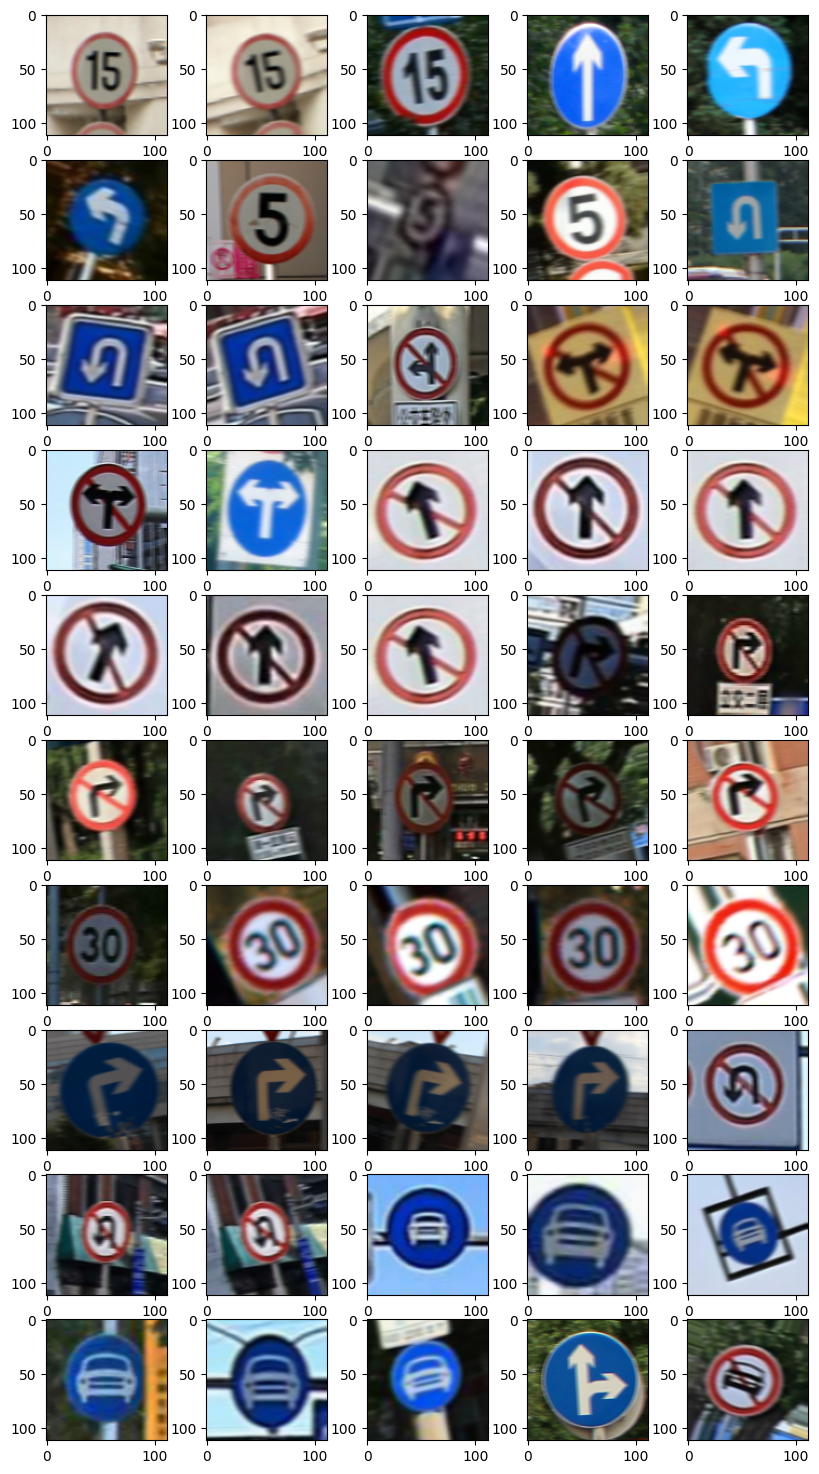

In [14]:
fig = plt.figure(figsize=(10,75))
row = int(round(200/5))
col = 5
anchor = 0
max = 50

for i in range(anchor, anchor+max):
    fig.add_subplot(row, col, i+1)
    plt.imshow(registered_images[i*10])

In [15]:
registered_label_images = keras.utils.to_categorical(registered_label_images, num_classes=len(class_images))

In [16]:
x_train_images, x_val_images, y_train_images, y_val_images = train_test_split(registered_images, registered_label_images, test_size=0.2, random_state=35)

In [17]:
reshape_data = x_train_images.reshape(-1, x_train_images.shape[1]*x_train_images.shape[2]*x_train_images.shape[3])
# dilakukan flatten karena SMOTE meminta bentuk input nya seperti itu

label_data = y_train_images.copy()

sm = SMOTE(random_state=2)
tmp_resample, y_train_images = sm.fit_resample(reshape_data, label_data)

# ukuran nya dibalikin ke awal
x_train_images = tmp_resample.reshape(-1,x_train_images.shape[1],x_train_images.shape[2],x_train_images.shape[3])

In [18]:
# input_shape = (W_H_SIZE,W_H_SIZE,3)

# model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# for layer in model.layers[:-3]:
#     layer.trainable = False

# x = model.output
# x = GlobalAveragePooling2D()(x)

# # fully-connected layer
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(32, activation='relu')(x)

# # classification layer
# output = Dense(len(class_images), activation="softmax")(x)
# cnn = Model(inputs=model.input, outputs=output)

# # Visualize the model
# keras.utils.plot_model(cnn, expand_nested=True, dpi=60, show_shapes=True)

In [19]:
# input_shape = (W_H_SIZE,W_H_SIZE,3)

# model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# for layer in model.layers[:-3]:
#     layer.trainable = False

# x = model.output
# x = GlobalAveragePooling2D()(x)

# # fully-connected
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(32, activation='relu')(x)

# # classification layer
# output = Dense(len(class_images), activation="softmax")(x)
# cnn = Model(inputs=model.input, outputs=output)

# # Visualize the model
# keras.utils.plot_model(cnn, expand_nested=True, dpi=60, show_shapes=True)

94765736/94765736 [==============================] - 1s 0us/step


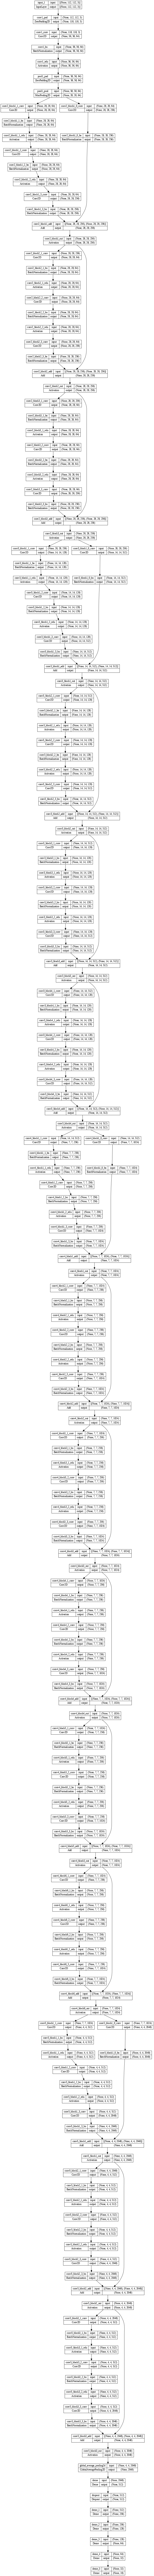

In [20]:
input_shape = (W_H_SIZE,W_H_SIZE,3)

model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in model.layers[:-3]:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)

# fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# classification layer
output = Dense(len(class_images), activation="softmax")(x)
cnn = Model(inputs=model.input, outputs=output)

keras.utils.plot_model(cnn, expand_nested=True, dpi=60, show_shapes=True)

In [21]:
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 118, 118, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 56, 56, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 56, 56, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [22]:
# record resource before training
mem_report()

CPU RAM Free: 7.5 GB
GPU 0 ... Mem Free: 14743MB / 15360MB | Utilization   2%


In [23]:
import numpy as np
from keras.callbacks import History
import time

# membuat callback untuk mencatat waktu training
class TimingCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        logs['epoch_time'] = epoch_time

def train_model():
    timing_callback = TimingCallback()

    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = cnn.fit(x_train_images, y_train_images, validation_data=(x_val_images, y_val_images),
                    epochs=50, callbacks=[timing_callback], verbose=1)

    epoch_times = history.history['epoch_time']

    average_time_per_epoch = np.mean(epoch_times)

    print(f'Epoch times: {epoch_times}')
    print(f'Average time per epoch: {average_time_per_epoch} seconds')

    return history

history = train_model()

Epoch 1/50
123/123 [==============================] - 18s 76ms/step - loss: 2.5808 - accuracy: 0.1439 - val_loss: 2.4338 - val_accuracy: 0.2154 - epoch_time: 18.1911
Epoch 2/50
123/123 [==============================] - 5s 39ms/step - loss: 2.1147 - accuracy: 0.2829 - val_loss: 2.0209 - val_accuracy: 0.3265 - epoch_time: 4.7539
Epoch 3/50
123/123 [==============================] - 5s 43ms/step - loss: 1.7124 - accuracy: 0.4128 - val_loss: 1.6387 - val_accuracy: 0.4172 - epoch_time: 5.2455
Epoch 4/50
123/123 [==============================] - 5s 37ms/step - loss: 1.4561 - accuracy: 0.5097 - val_loss: 1.6492 - val_accuracy: 0.4172 - epoch_time: 4.5500
Epoch 5/50
123/123 [==============================] - 5s 37ms/step - loss: 1.3308 - accuracy: 0.5554 - val_loss: 1.2337 - val_accuracy: 0.5556 - epoch_time: 4.5295
Epoch 6/50
123/123 [==============================] - 5s 43ms/step - loss: 1.1955 - accuracy: 0.5995 - val_loss: 1.1985 - val_accuracy: 0.5850 - epoch_time: 5.2895
Epoch 7/50
123

In [24]:
# record resource after training
mem_report()

CPU RAM Free: 5.8 GB
GPU 0 ... Mem Free: 6531MB / 15360MB | Utilization  56%


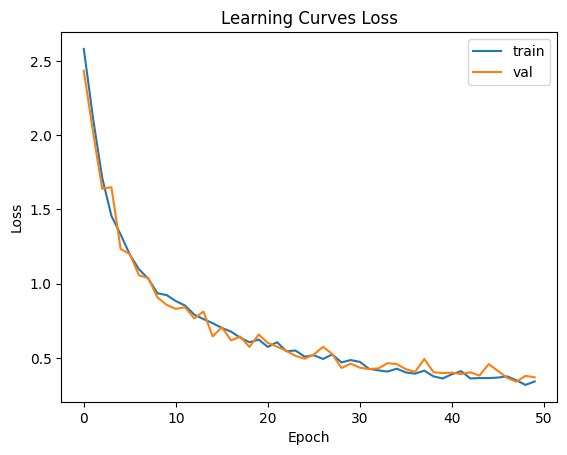

In [25]:
from matplotlib import pyplot
pyplot.title('Learning Curves Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

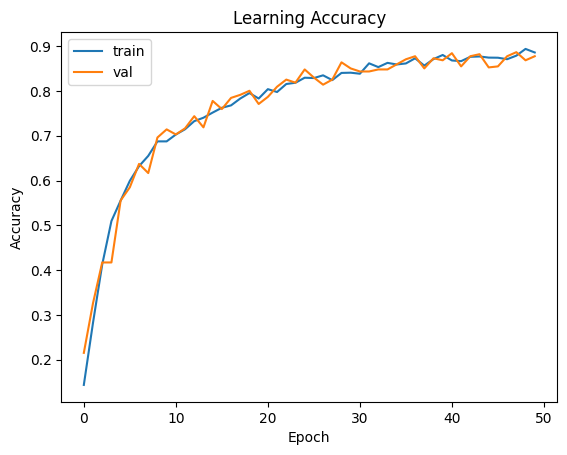

In [26]:
from matplotlib import pyplot
pyplot.title('Learning Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [27]:
registered_test_images, registered_test_label_images, class_images_test = pre_processing_data_test(DATASET_IMAGE_TEST, normalization=min_max_scaler, image_data_generator=image_augmentation)

registered_test_images = np.array(registered_test_images)
registered_test_label_images = np.array(registered_test_label_images)

print(registered_test_images.shape)

(561, 112, 112, 3)


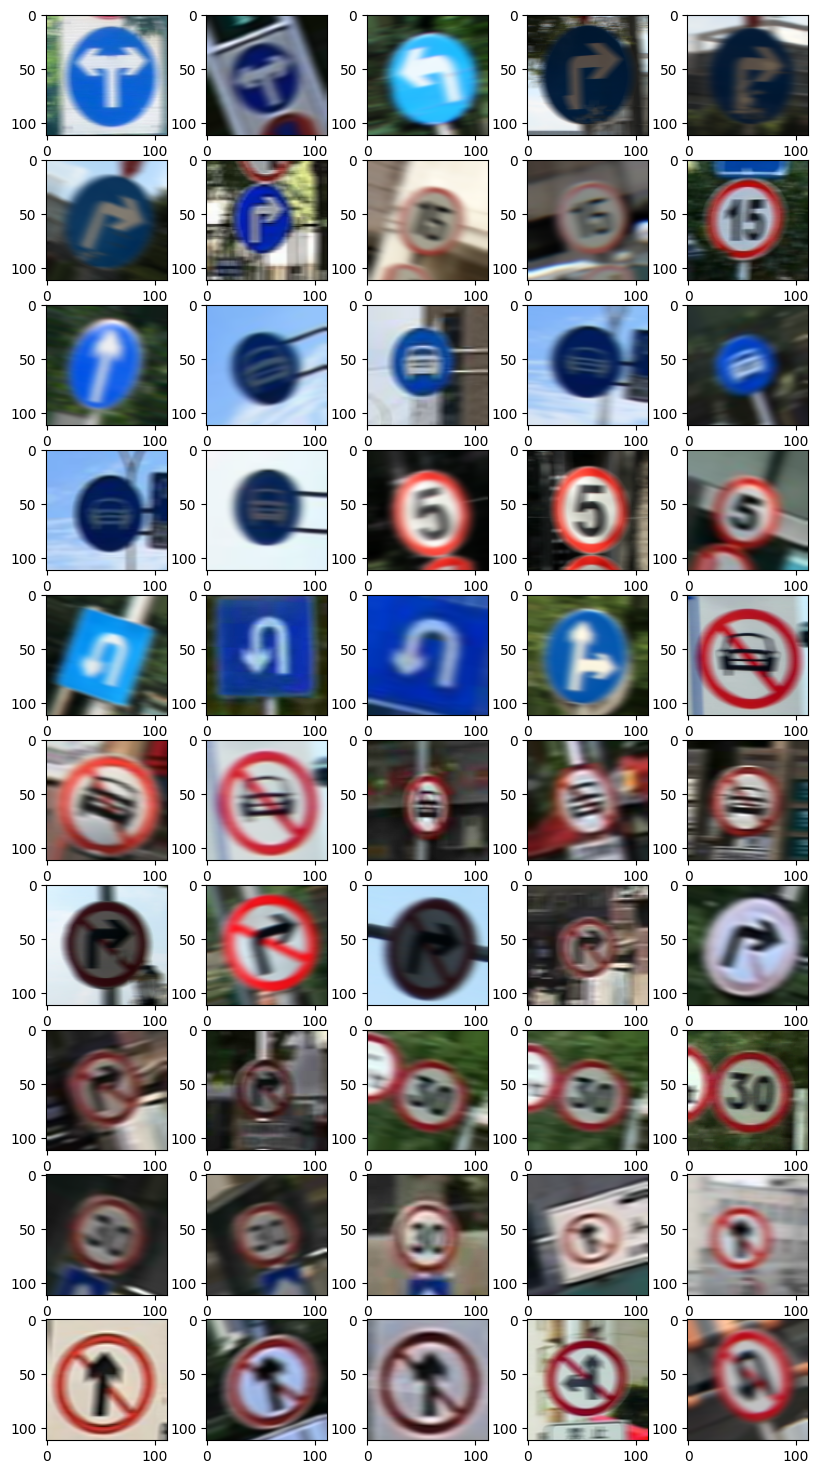

In [28]:
fig = plt.figure(figsize=(10,75))
row = int(round(200/5))
col = 5
anchor = 0
max = 50

for i in range(anchor, anchor+max):
    fig.add_subplot(row, col, i+1)
    plt.imshow(registered_test_images[i*10])

In [29]:
registered_test_label_images = keras.utils.to_categorical(registered_test_label_images, num_classes=len(class_images_test))

In [30]:
cnn.save("cnn_model.h5")
del(cnn)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
cnn = load_model("cnn_model.h5")

In [32]:
cnn_predict = cnn.predict(registered_test_images)

18/18 [==============================] - 3s 83ms/step


In [33]:
print(classification_report(np.argmax(registered_test_label_images, axis=1), np.argmax(cnn_predict, axis=1)))

              precision    recall  f1-score   support

           0       0.48      0.96      0.64        27
           1       0.48      0.50      0.49        30
           2       0.74      0.69      0.71        54
           3       1.00      0.83      0.91        12
           4       1.00      0.80      0.89        54
           5       0.90      0.90      0.90        30
           6       0.86      0.33      0.48        72
           7       1.00      0.48      0.65        42
           8       0.75      0.89      0.81        63
           9       0.67      0.83      0.74        12
          10       0.67      0.53      0.59        15
          11       0.68      1.00      0.81        15
          12       0.73      0.53      0.62        15
          13       0.60      0.88      0.72        33
          14       0.57      0.91      0.70        57
          15       0.57      0.40      0.47        30

    accuracy                           0.70       561
   macro avg       0.73   

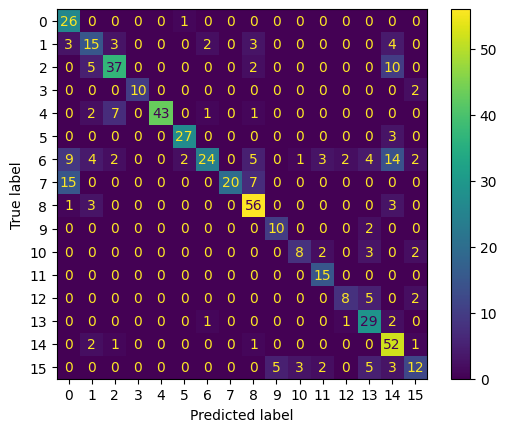

In [34]:
ConfusionMatrixDisplay.from_predictions(y_true=np.argmax(registered_test_label_images, axis=1), y_pred=np.argmax(cnn_predict, axis=1), labels=[i for i in range(len(class_images_test))])

18/18 [==============================] - 1s 30ms/step


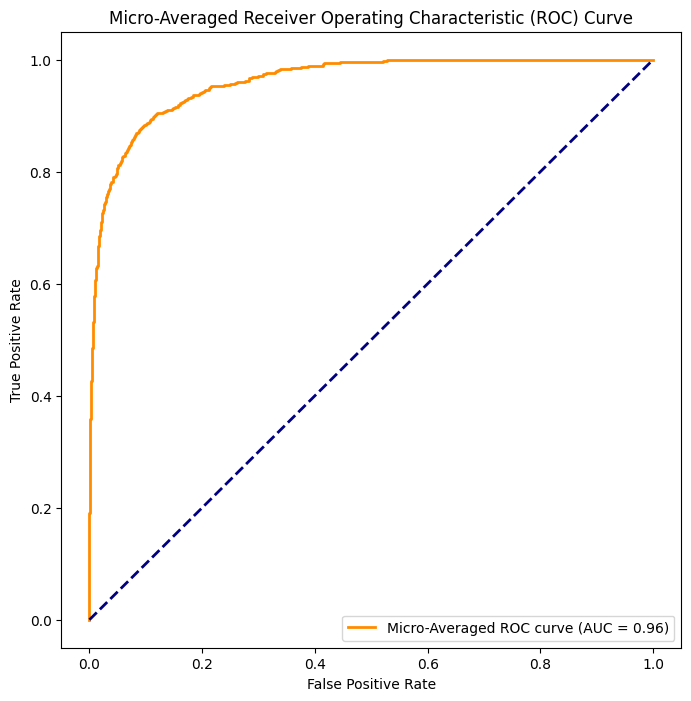

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_probs = cnn.predict(registered_test_images)

fpr, tpr, _ = roc_curve(registered_test_label_images.ravel(), y_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Micro-Averaged ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
